In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import odeint, solve_ivp



import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits import mplot3d
import random as random
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

In [3]:
# The SUPER POINTS!!!

index = np.arange(0,7,1)
print(index)
S = [-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
L = [.0799,.4289,.7338,.8011,.7616,.7616,.6299]
U = [.5850,.5085,-.1047,-.1047,.1899,.8684,1.133]
R = [2.492,2.499,2.019,np.pi/2,1.477,.6686,.6686]
B = [-1.229,-1.225,-1.246,0,.6196,1.362,1.526]
T = [np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi]

[0 1 2 3 4 5 6]


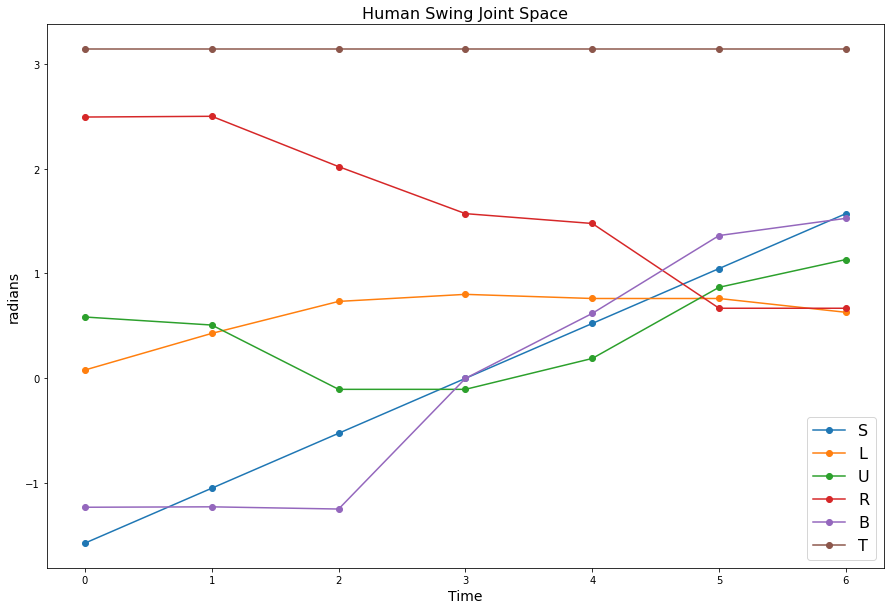

In [4]:
#Plot them all
# creating an empty canvas
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
ax.plot(index,S,'-o',index,L,'-o',index,U,'-o',index,R,'-o',index,B,'-o',index,T,'-o')
plt.legend(['S','L','U','R','B','T'],fontsize = 16)
ax.set_title('Human Swing Joint Space',fontsize = 16)
ax.set_xlabel('Time',fontsize = 14)
ax.set_ylabel('radians',fontsize = 14)
plt.show()

[2.492      2.4924375  2.492875   2.4933125  2.49375    2.4941875
 2.494625   2.4950625  2.4955     2.4959375  2.496375   2.4968125
 2.49725    2.4976875  2.498125   2.4985625  2.499      2.469
 2.439      2.409      2.379      2.349      2.319      2.289
 2.259      2.229      2.199      2.169      2.139      2.109
 2.079      2.049      2.019      1.99098727 1.96297454 1.93496181
 1.90694908 1.87893635 1.85092362 1.82291089 1.79489816 1.76688543
 1.7388727  1.71085997 1.68284725 1.65483452 1.62682179 1.59880906
 1.57079633 1.56493406 1.55907179 1.55320952 1.54734725 1.54148497
 1.5356227  1.52976043 1.52389816 1.51803589 1.51217362 1.50631135
 1.50044908 1.49458681 1.48872454 1.48286227 1.477      1.426475
 1.37595    1.325425   1.2749     1.224375   1.17385    1.123325
 1.0728     1.022275   0.97175    0.921225   0.8707     0.820175
 0.76965    0.719125   0.6686     0.6686     0.6686     0.6686
 0.6686     0.6686     0.6686     0.6686     0.6686     0.6686
 0.6686     0.6686     0.6

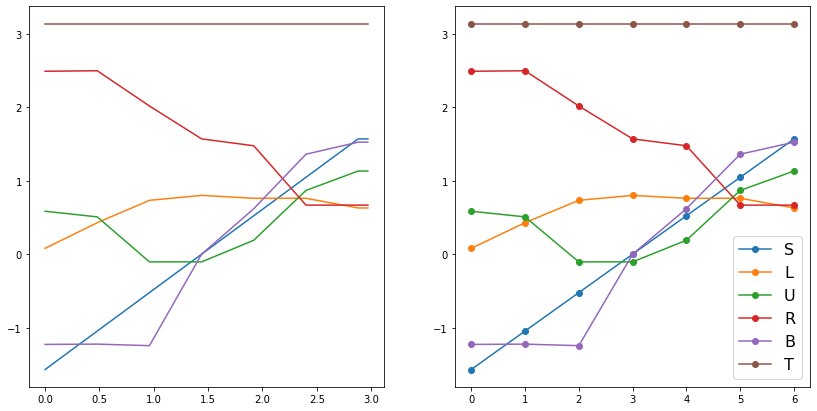

In [5]:
#Make all the theta vectors 100 points with linear interpolation


pts = 100


def Interp(theta,pts):
    add = np.floor(pts/(len(theta)-1))
    parts = np.zeros((6,int(add)))
    long_theta = []
                     
    for i in range(int(len(theta)-1)):
        delta = (theta[i+1]-theta[i])/add
        parts[i] = np.linspace(theta[i],theta[i+1]-delta,int(add))
    for j in range(int(len(parts))):
        long_theta = np.append(long_theta,parts[j])
    
    while len(long_theta)<pts:
        long_theta = np.append(long_theta,theta[-1])
    
    return long_theta

long_S = Interp(S,pts)
long_L = Interp(L,pts)
long_U = Interp(U,pts)
long_R = Interp(R,pts)
long_B = Interp(B,pts)
long_T = Interp(T,pts)
    
print(long_R)

t_start = 0
t_end =3
delta_t = t_end/pts
t_pts = np.arange(t_start,t_end,delta_t)

fig2 = plt.figure(figsize = (14,7))
ax2 = fig2.add_subplot(1,2,1)
ax3 = fig2.add_subplot(1,2,2)
ax2.plot(t_pts,long_S,'-')
ax2.plot(t_pts,long_L,'-')
ax2.plot(t_pts,long_U,'-')
ax2.plot(t_pts,long_R,'-')
ax2.plot(t_pts,long_B,'-')
ax2.plot(t_pts,long_T,'-')
ax3.plot(index,S,'-o')
ax3.plot(index,L,'-o')
ax3.plot(index,U,'-o')
ax3.plot(index,R,'-o')
ax3.plot(index,B,'-o')
ax3.plot(index,T,'-o')
plt.legend(['S','L','U','R','B','T'],fontsize = 16)
plt.show()

In [6]:
#Back to my robot vectors stuff. 

class Robot():
    
    #Class for the robot with lengths of links and the axis defined as they would be in the defalt zero position
    
    def __init__(self, links, axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0],[1,0,0]]):
        self.links = links
        self.axis = axis
        
    def rotateAxis(self, t, vec):
        
        #Rotation matrix just taken straight from wikepedia
        
        C = 1-np.cos(t);
        x,y,z = vec;

        Rot = [[x**2*C+np.cos(t), x*y*C-z*np.sin(t), z*x*C+y*np.sin(t)],
                [x*y*C+z*np.sin(t), y**2*C+np.cos(t), z*y*C-x*np.sin(t)],
                [x*z*C-y*np. sin(t), y*z*C+x*np.sin(t), z**2*C+np.cos(t)]]

        return Rot

    def findEnd(self, angles):
        #This function takes an input vector of angles and will output the end position as
        #well as all of the vectors of the robot NOT TRANSLATED FROM THE ORIGIN
        
        v1 = [0,0,0] #Base thing that moves with S
        v2 = [0,0,0] #First link that moves with L
        v3 = [0,0,0] #Second link that moves with U
        v4 = [0,0,0] #Shaft link that moves with B
        v5 = [0,0,0] #Club head that moves with T/R
        
        #Starting Vector
        v1_0 = [self.links[0]/np.sqrt(2),0,self.links[0]/np.sqrt(2)]
        v5_0 = [self.links[4]*np.cos(np.pi/6),self.links[4]*np.cos(np.pi/12),self.links[4]*np.cos(np.pi/3)]
        
        #First rotation
        v1 = np.dot(v1_0,self.rotateAxis(angles[0], self.axis[0]))
        axis1 = np.dot(self.axis[1],self.rotateAxis(angles[0], self.axis[0]))
        axis2 = np.dot(self.axis[2],self.rotateAxis(angles[0], self.axis[0]))
        axis3 = np.dot(self.axis[3],self.rotateAxis(angles[0], self.axis[0]))
        axis4 = np.dot(self.axis[4],self.rotateAxis(angles[0], self.axis[0]))
        
        #Second Rotation
        v2 = (self.links[1]/self.links[0])*np.dot(v1,self.rotateAxis(angles[1], axis1))
        axis2 = np.dot(axis2,self.rotateAxis(angles[1], axis1))
        axis3 = np.dot(axis3,self.rotateAxis(angles[1], axis1))
        axis4 = np.dot(axis4,self.rotateAxis(angles[1], axis1))
        
        #Third Rotation
        v3 = (self.links[2]/self.links[1])*np.dot(v2,self.rotateAxis(angles[2], axis2))
        axis3 = np.dot(axis3,self.rotateAxis(angles[2], axis2))
        axis4 = np.dot(axis4,self.rotateAxis(angles[2], axis2))

        #Fourth rotation
        axis3 = np.dot(axis3,self.rotateAxis(angles[3], v3))
        axis4 = np.dot(axis4,self.rotateAxis(angles[3], v3))
        
        #Fifth Rotation
        v4 = (self.links[3]/self.links[2])*np.dot(v3,self.rotateAxis(angles[4], axis3))
        axis4 = np.dot(axis4,self.rotateAxis(angles[4], axis3))
        
        #Sixth Rotation
        v5 = np.dot(v5_0,self.rotateAxis(angles[5], axis4))
        
        
        x_val = v1[0]+v2[0]+v3[0]+v4[0]+v5[0]
        y_val = v1[1]+v2[1]+v3[1]+v4[1]+v5[1]
        z_val = v1[2]+v2[2]+v3[2]+v4[2]+v5[2]
        
        return [x_val, y_val, z_val, v1, v2, v3, v4, v5]
    
    def distanceFromTarget(self,targ,angles):
        
        #Simply finds the distance between a given end from a set of angles and a target end point
        
        end = self.findEnd(angles)
        dist = (end[0]-targ[0])**2+(end[1]-targ[1])**2+(end[2]-targ[2])**2
        
        return dist
    



In [7]:
def drawRobot(v1,v2,v3,v4,v5):
    
    #I guess the name of this function is deceptive but it takes the vectors and translates them essentially
    
    x = np.zeros(100,)
    y = np.zeros(100,)
    z = np.zeros(100,)

    # This is an admittedly weird way to do this, but it is what it is.
    # The process is like walking along in the direction of vectors 1-5 until you reach the end
    # The magnitude of the links are arbitrary but the relative size is still normal as defined
    
    for i in range(100):
        if i <= 19:
            x[i] = i*v1[0]
            y[i] = i*v1[1]
            z[i] = i*v1[2]
        elif i > 19 and i<=39:
            x[i] = 19*v1[0] + (i-19)*v2[0]
            y[i] = 19*v1[1] + (i-19)*v2[1]
            z[i] = 19*v1[2] + (i-19)*v2[2]
        elif i > 39 and i<=59:
            x[i] = 19*v1[0] + 20*v2[0]+ (i-39)*v3[0]
            y[i] = 19*v1[1] + 20*v2[1]+ (i-39)*v3[1]
            z[i] = 19*v1[2] + 20*v2[2]+ (i-39)*v3[2]
        elif i > 59 and i<=79:
            x[i] = 19*v1[0] + 20*v2[0] + 20*v3[0] + (i-59)*v4[0]
            y[i] = 19*v1[1] + 20*v2[1] + 20*v3[1] + (i-59)*v4[1]
            z[i] = 19*v1[2] + 20*v2[2] + 20*v3[2] + (i-59)*v4[2]
        else:
            x[i] = 19*v1[0] + 20*v2[0] + 20*v3[0] + 20*v4[0] + (i-79)*v5[0]
            y[i] = 19*v1[1] + 20*v2[1] + 20*v3[1] + 20*v4[1] + (i-79)*v5[1]
            z[i] = 19*v1[2] + 20*v2[2] + 20*v3[2] + 20*v4[2] + (i-79)*v5[2]
    
    return x,y,z

In [8]:
def drawRobot2(v1,v2,v3,v4,v5):
    
    x = np.zeros(6,)
    y = np.zeros(6,)
    z = np.zeros(6,)
    
    [x[0],y[0],z[0]] = [0,0,0]
    [x[1],y[1],z[1]] = v1
    [x[2],y[2],z[2]] = v1+v2
    [x[3],y[3],z[3]] = v1+v2+v3
    [x[4],y[4],z[4]] = v1+v2+v3+v4
    [x[5],y[5],z[5]] = v1+v2+v3+v4+v5
    
    print(x)
    print(y)
    print(z)
    
    return x,y,z

    


[0.8366051659376018, 0.019318516525781367, -0.1646004667986545]


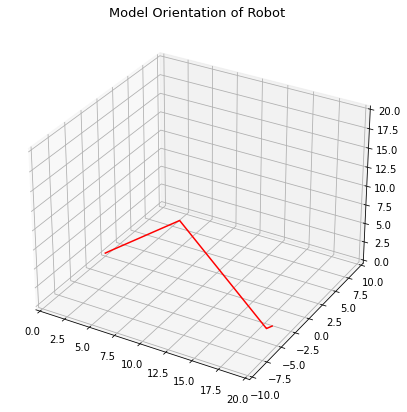

In [9]:
#Defining a instance of the robot
links = [.04,.5,.5,.2,.02]
#links = [3,10,10,7.5,1]
axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0],[1,0,0]]

S = [-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
L = [.0799,.4289,.7338,.8011,.7616,.7616,.6299]
U = [.5850,.5085,-.1047,-.1047,.1899,.8684,1.133]
R = [2.492,2.499,2.019,np.pi/2,1.477,.6686,.6686]
B = [-1.229,-1.225,-1.246,0,.6196,1.362,1.526]
T = [np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi]

#anglesDesired = [np.pi/4,0,0,np.pi/2,np.pi/2,0]
anglesDesired = [S[3],L[3],U[3],R[3],B[3],T[3]]
#anglesDesired = [0,.5,.5,10,1,10]

#Changing from normal physics conventions of angle definition to the way the robot defines them:
anglesConvention = [-1*anglesDesired[0],(np.pi/4-anglesDesired[1]),\
                    (-np.pi/2+anglesDesired[2]),anglesDesired[3],-1*anglesDesired[4],np.pi-anglesDesired[5]]

Moto = Robot(links = links, axis = axis)
End = Moto.findEnd(anglesConvention)
print([End[0],End[1],End[2]])

#Show on a 3D plot

v1,v2,v3,v4,v5 = End[3],End[4],End[5],End[6],End[7]

x,y,z = drawRobot(v1,v2,v3,v4,v5)
             
#print(x)
#print(y)
#print(z) 


# creating an empty canvas
fig = plt.figure(figsize = (7,7))

# defining the axes with the projection
# as 3D so as to plot 3D graphs
ax = plt.axes(projection="3d")
ax.set_xlim(0,20)
ax.set_ylim(-10,10)
ax.set_zlim(0,20)

# plotting a 3D line graph with X-coordinate,
# Y-coordinate and Z-coordinate respectively
ax.plot3D(x,y,z, 'red')


 
# Showing the above plot
plt.title('Model Orientation of Robot',fontsize=13)
plt.show()

In [10]:
#Try some hill climbing


print(End)
Target = [End[0],End[1],End[2]]

angles_start = np.array([anglesConvention[0],anglesConvention[1],\
                   anglesConvention[2],anglesConvention[3],anglesConvention[4]-.17,anglesConvention[5]])

angles = angles_start
#Step size for the hill searching
step = 1e-2

    
dist = Moto.distanceFromTarget(Target,angles)   


for i in range(1000): #Hill climb starts
    
    #print(angles)
    dist = Moto.distanceFromTarget(Target,angles) #Try something
    #print(dist)
    
    #look somewhere else but don't use all the angles
    
    # I can only move S, L, and U:
    angles_test = [angles[0]+step*random.uniform(-1,1),angles[1]+step*random.uniform(-1,1),\
                   angles[2]+step*random.uniform(-1,1),angles[3],\
                   angles[4],angles[5]]
    
    
    #print(angles_test)
    dist_test = Moto.distanceFromTarget(Target,angles_test) #try that
    #print(dist_test)
    
    #What it better?
    if dist_test<=dist:
        angles = angles_test;
        #print('Angles Changed')
    else:
        continue
        
print(angles)
print(anglesConvention)

[0.8366051659376018, 0.019318516525781367, -0.1646004667986545, array([0.02828427, 0.        , 0.02828427]), array([0.35906102, 0.        , 0.3479586 ]), array([ 0.30852812,  0.        , -0.39345953]), array([ 0.12341125,  0.        , -0.15738381]), array([0.01732051, 0.01931852, 0.01      ])]
[-0.021322663000993, -0.021412061354731445, -1.6693286564393375, 1.5707963267948966, -0.17, 0.0]
[0, -0.015701836602551755, -1.6754963267948966, 1.5707963267948966, 0, 0.0]


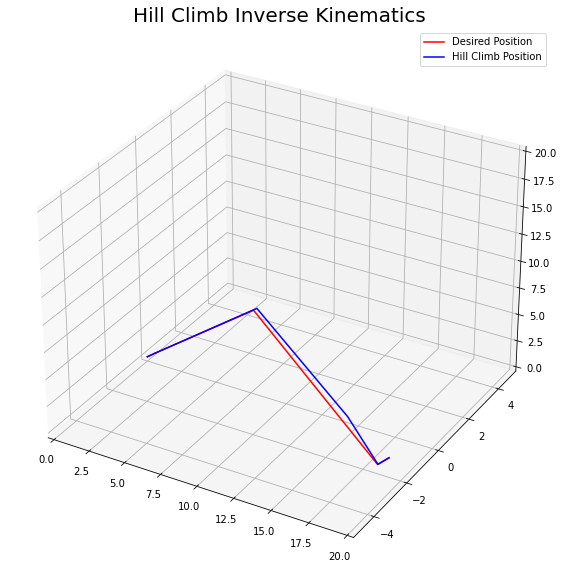

In [11]:
#Print everything on top of each other to see how good the hill climb is
Moto_hc = Robot(links = links, axis = axis)
End_hc = Moto_hc.findEnd(angles)
End_0 = Moto.findEnd(angles_start)

v1_hc,v2_hc,v3_hc,v4_hc,v5_hc = End_hc[3],End_hc[4],End_hc[5],End_hc[6],End_hc[7]
x_hc,y_hc,z_hc = drawRobot(v1_hc,v2_hc,v3_hc,v4_hc,v5_hc)

v1_0, v2_0, v3_0, v4_0,v5_0 = End_0[3],End_0[4],End_0[5],End_0[6],End[7]
x_0,y_0,z_0 = drawRobot(v1_0,v2_0,v3_0,v4_0,v5_0)

#Desired Robot:
End_desired = Moto.findEnd(anglesConvention)
#print(x)
#print(y)
#print(z) 


# creating an empty canvas
fig2 = plt.figure(figsize = (10,10))
 
# defining the axes with the projection
# as 3D so as to plot 3D graphs
ax2 = plt.axes(projection="3d")
ax2.set_xlim(0,20)
ax2.set_ylim(-5,5)
ax2.set_zlim(0,20)
# plotting a 3D line graph with X-coordinate,
# Y-coordinate and Z-coordinate respectively
ax2.plot3D(x,y,z,'red')
ax2.plot3D(x_hc,y_hc,z_hc,'blue')
#ax2.plot3D(x_0,y_0,z_0,'orange')
ax2.legend(['Desired Position','Hill Climb Position','Inital Guess'])

 
# Showing the above plot
plt.title('Hill Climb Inverse Kinematics',fontsize=20)
plt.show()


In [24]:
#Make a bunch of center points with a -5 to 5 degree spread for B and T
theta_start = -5*np.pi/180
theta_end = 5*np.pi/180
d_theta = (theta_end-theta_start)/25
angle_range = np.arange(theta_start,theta_end,d_theta)

num = int(len(angle_range))
print(num)
size = num**2
print(size)
matrix_index = 0;
Angles_Matrix = np.zeros((6,size),)

for i in range(int(len(angle_range))):
    for j in range(int(len(angle_range))):
        
        Target = [End[0],End[1],End[2]] # The end position for B = 0, T = pi, S = 0, R = whatever it is
        angles_start = np.array([anglesConvention[0],anglesConvention[1],\
                           anglesConvention[2],anglesConvention[3],anglesConvention[4]+angle_range[i],\
                                 anglesConvention[5]+angle_range[j]])

        
        angles = angles_start #First Try       
        step = 1e-2 #Step size for the hill searching
        dist = Moto.distanceFromTarget(Target,angles) #How far it is from the home positon at the beginning 


        for k in range(1000): #Hill climb starts

            #print(angles)
            dist = Moto.distanceFromTarget(Target,angles) #Try something
            #print(dist)

            #look somewhere else but don't use all the angles

            # I can only move S, L, and U:
            angles_test = [angles[0]+step*random.uniform(-1,1),angles[1]+step*random.uniform(-1,1),\
                           angles[2]+step*random.uniform(-1,1),angles[3],\
                           angles[4],angles[5]]


            #print(angles_test)
            dist_test = Moto.distanceFromTarget(Target,angles_test) #try that
            #print(dist_test)

            #Was it better?
            if dist_test<=dist:
                angles = angles_test;
                #print('Angles Changed')
            else:
                continue

        #print(angles)
        #print(anglesConvention)
        Angles_Matrix[:,matrix_index] = angles
        matrix_index +=1
    
print(Angles_Matrix)

25
625
[[-0.01002549 -0.01056661 -0.01120695 ...  0.01039306  0.01080074
   0.01084926]
 [-0.01714737 -0.01974233 -0.01700469 ... -0.01707677 -0.01508116
  -0.0165327 ]
 [-1.6747944  -1.67211341 -1.67541273 ... -1.67393495 -1.67637134
  -1.67490909]
 [ 1.57079633  1.57079633  1.57079633 ...  1.57079633  1.57079633
   1.57079633]
 [-0.08726646 -0.08726646 -0.08726646 ...  0.08028515  0.08028515
   0.08028515]
 [-0.08726646 -0.08028515 -0.07330383 ...  0.06632251  0.07330383
   0.08028515]]
